### Gaussian Process Regression

Let's say we observe some data where $X$ are the variables and $y$ is the target.

$$\mathcal{D} = \{(\mathbf{x}_i, y_i\}_{i=1}^{n} = (\mathbf{X},y)$$

We want to model our data as

$$y_i = f(x_i) + \epsilon_i$$

where $f \sim GP(0,K)$ and $\epsilon \sim N(0, \sigma^2)$

We place a prior on $f$ (a prior of functional forms). The Likelihood is Gaussian therefore the posterior is a GP.



Source: http://mlss2011.comp.nus.edu.sg/uploads/Site/lect1gp.pdf

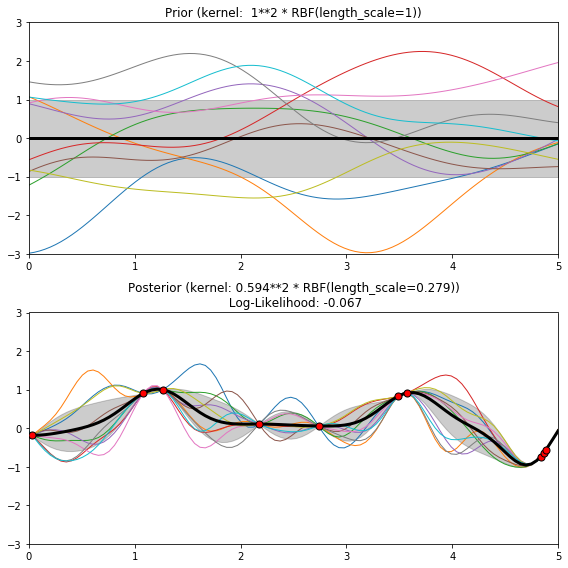

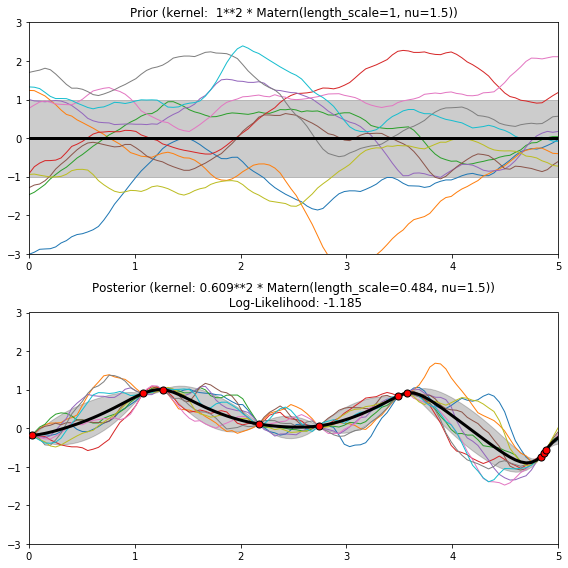

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C
plt.rcParams['figure.figsize'] = (10, 5)

kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]

for fig_index, kernel in enumerate(kernels):
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior
    plt.figure(fig_index, figsize=(8, 8))
    plt.subplot(2, 1, 1)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

    # Generate data and fit GP
    rng = np.random.RandomState(4)
    X = rng.uniform(0, 5, 10)[:, np.newaxis]
    y = np.sin((X[:, 0] - 2.5) ** 2)
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

plt.show()


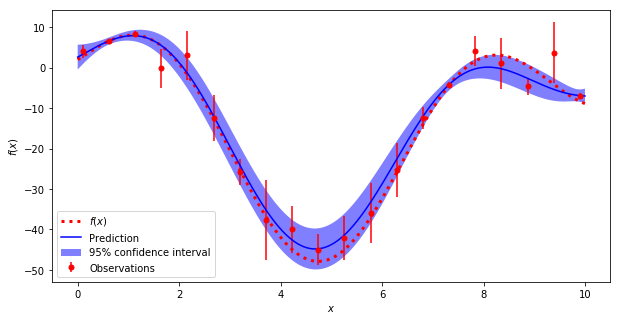

In [10]:
def f(x):
    """The function to predict."""
    return 1.2*x**2 - 12*x + 2 + 20*np.sin(x)

X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# kernel = DotProduct() + WhiteKernel()
# kernel = 1.0 * RBF(10, (1e-2, 1e2))
kernel = 1.0 * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e3)) + \
    WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 10 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x)$', linewidth=3)
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
# plt.ylim(-10, 20)
plt.legend(loc='lower left')

plt.show()

In [15]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
boston = load_boston()
X = boston['data']
y = boston['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train, y_train)
gpr.score(X_test,y_test)

0.709079688871838

In [45]:
kernel = 1.0*RBF(length_scale=1) + WhiteKernel(noise_level=1)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train, y_train)
gpr.score(X_test,y_test), gpr.score(X_train,y_train)

(0.8311264160635224, 0.9229602623611147)

In [30]:
kernel = 1.0*Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=50)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train, y_train)
gpr.score(X_test,y_test)

0.8221291008753667

In [50]:
kernel = 1.0*RBF(length_scale=1)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train, y_train)
gpr.score(X_train,y_train)

1.0